# Supervised

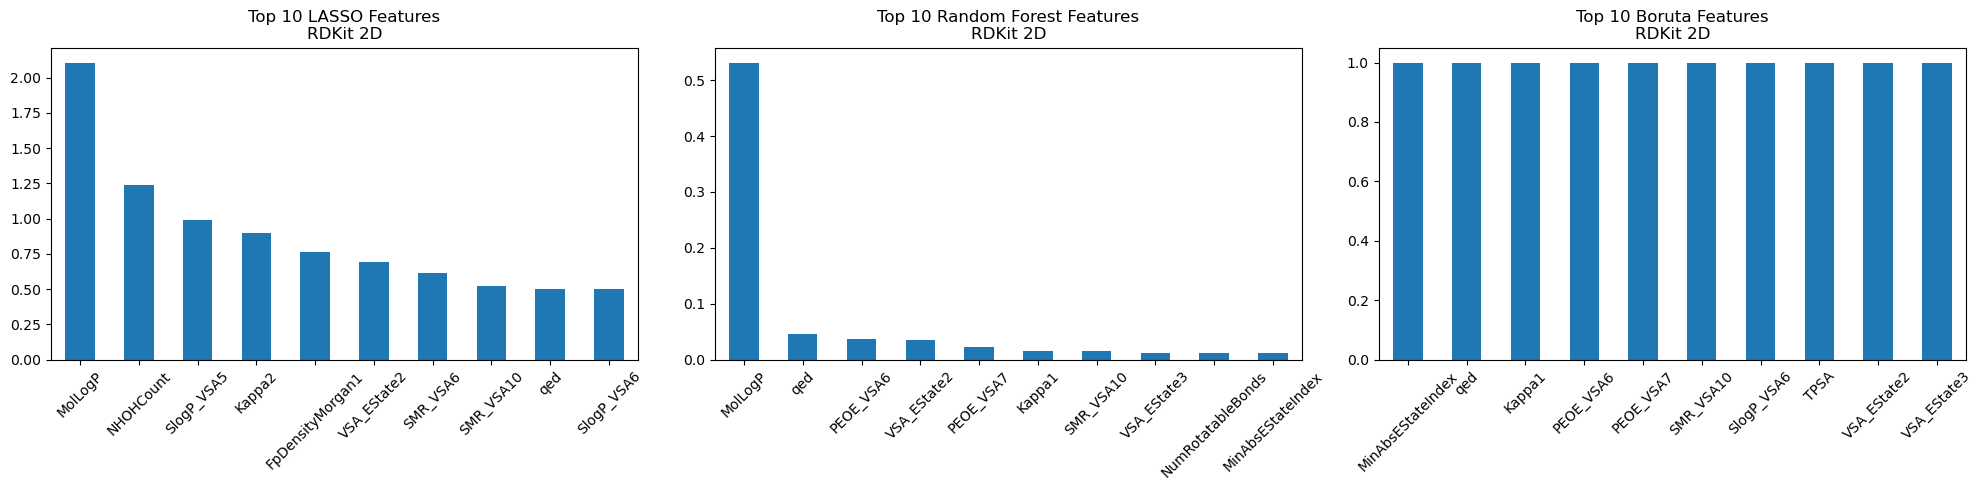

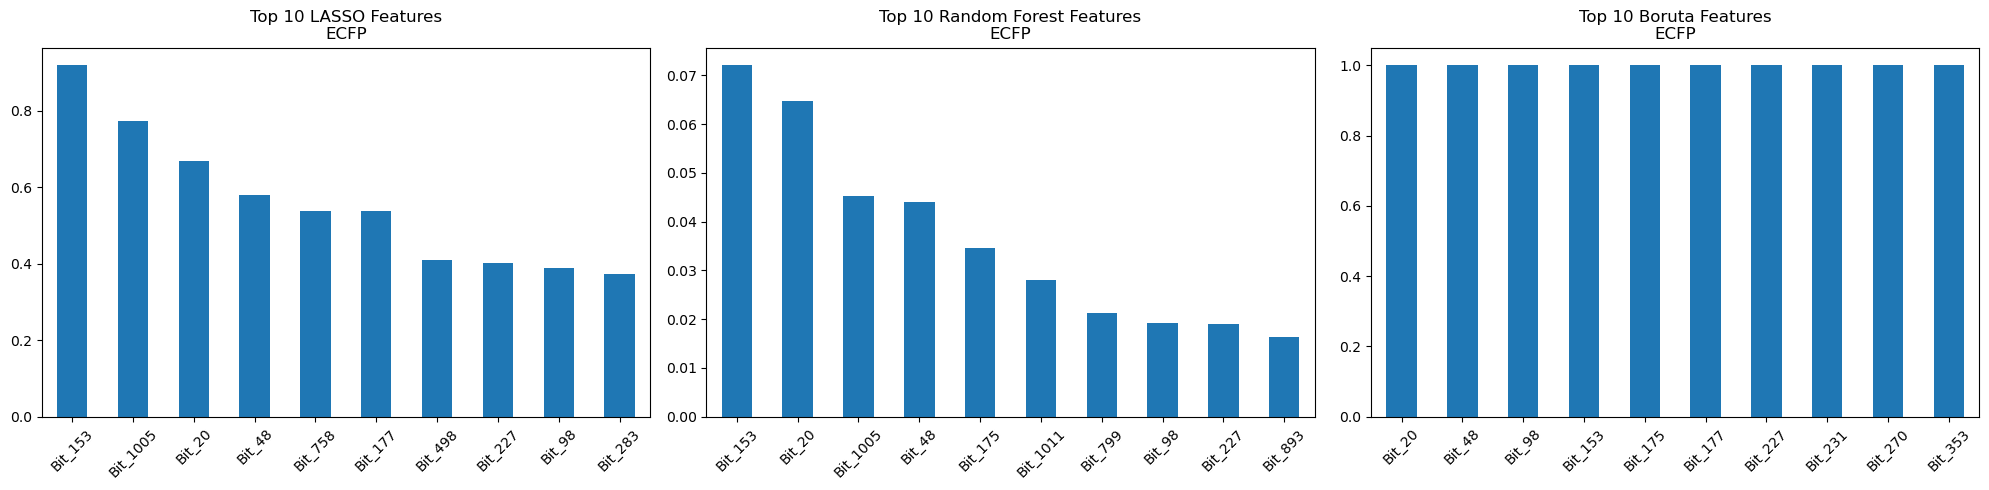

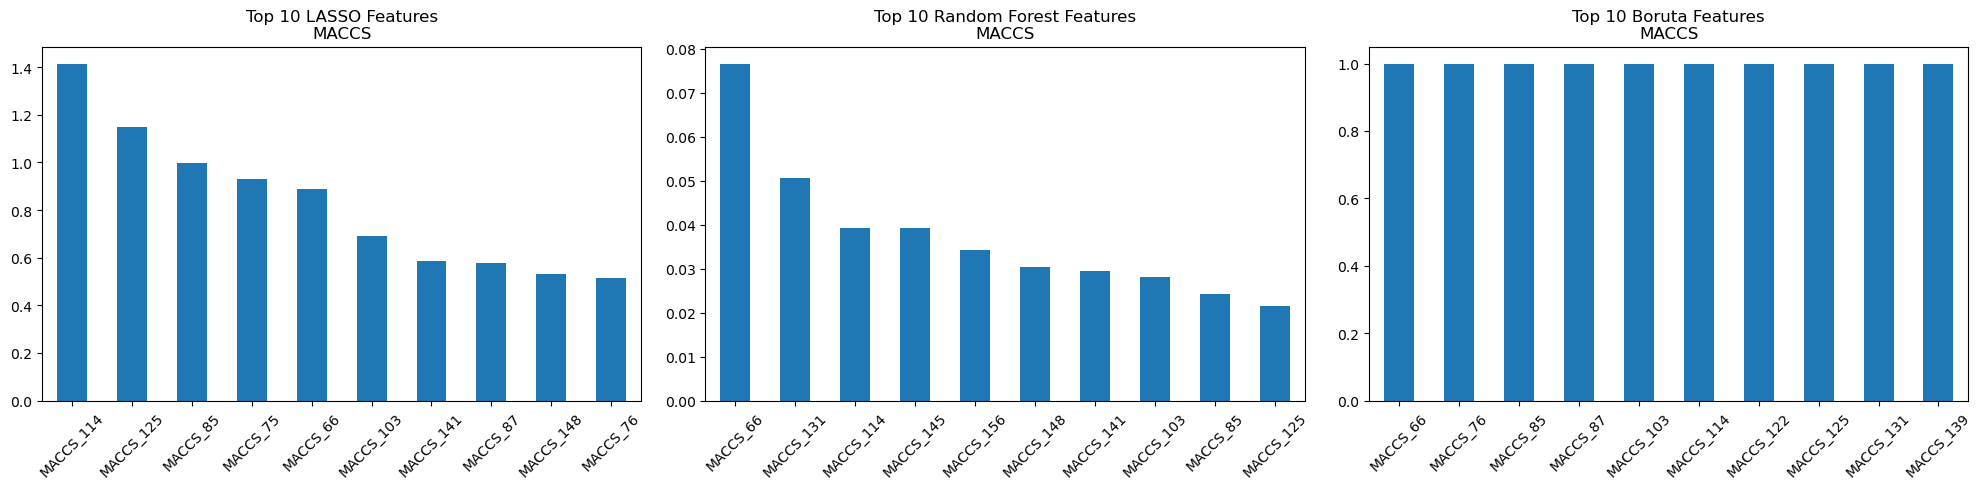

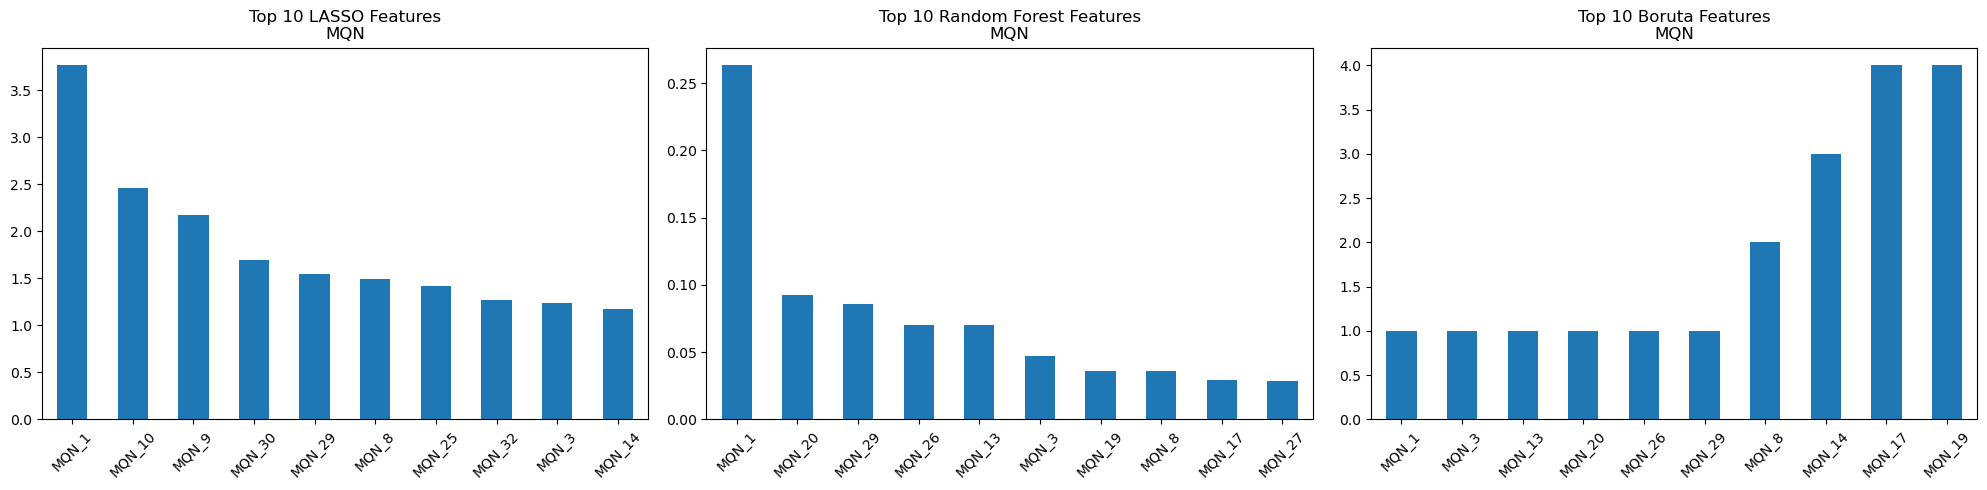

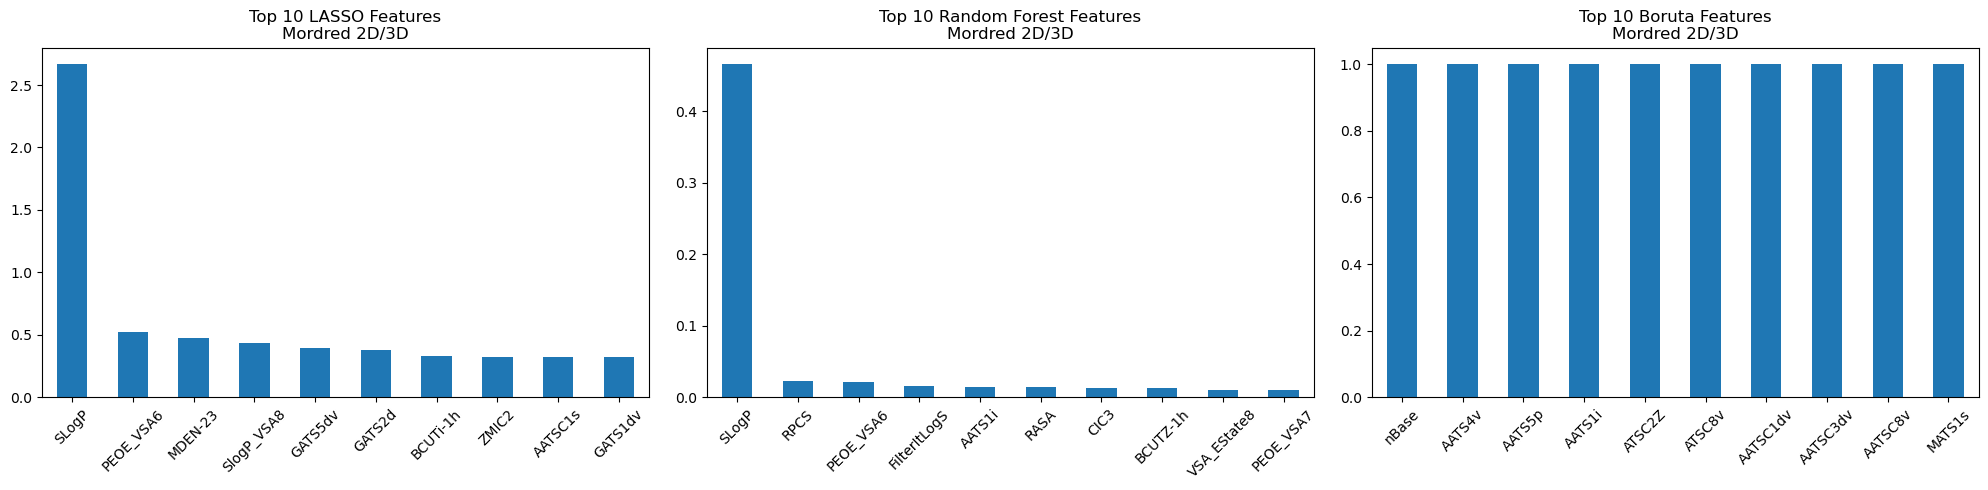

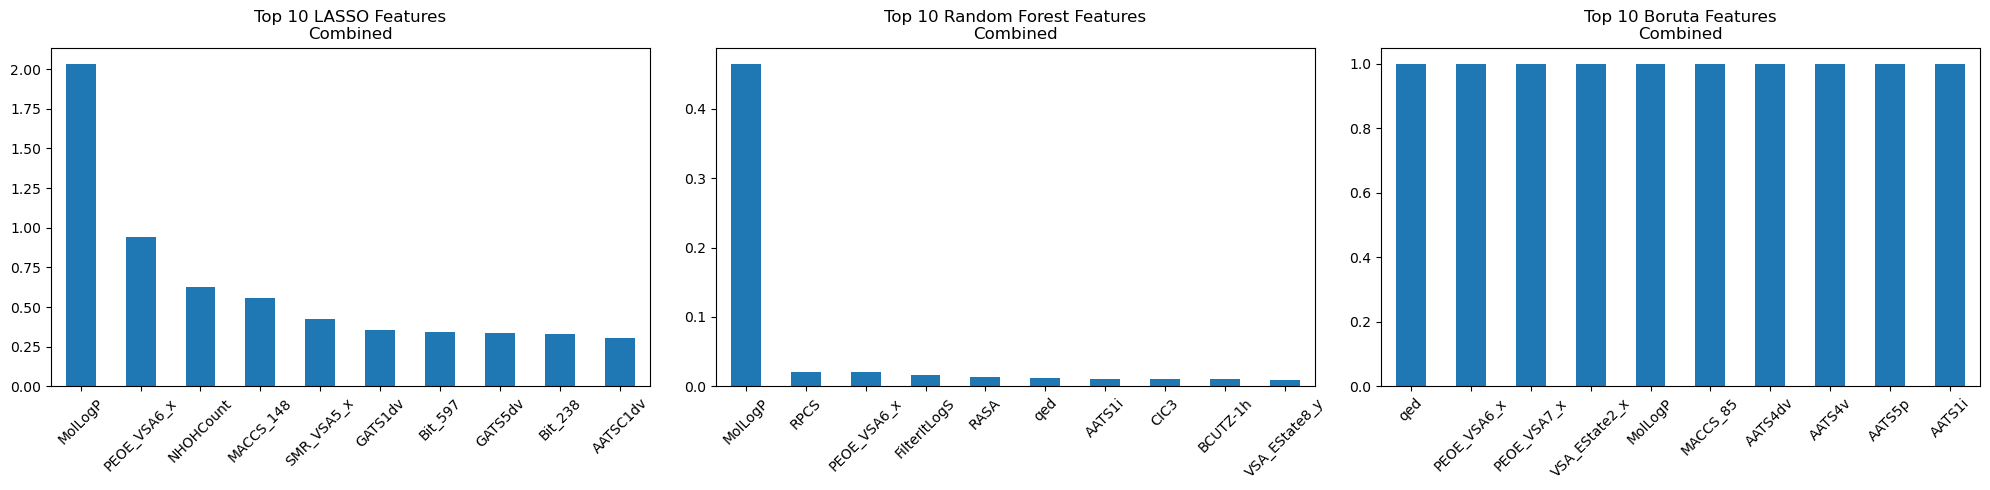

<Figure size 1000x600 with 0 Axes>

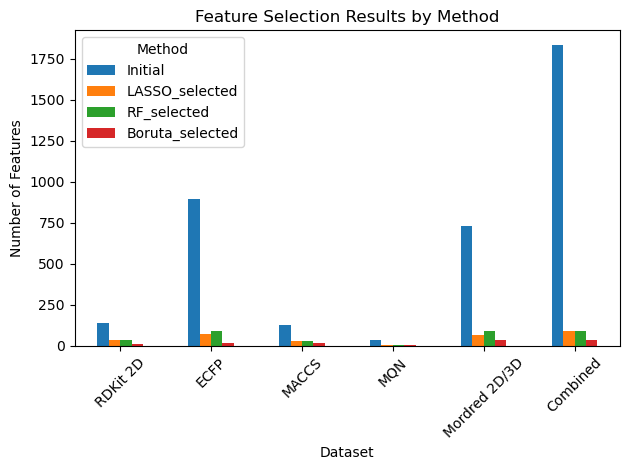


Results summary:
               Initial  LASSO_selected  RF_selected  Boruta_selected
Dataset                                                             
RDKit 2D           139              35           35               11
ECFP               893              74           91               17
MACCS              128              32           32               15
MQN                 33               8            8                6
Mordred 2D/3D      731              64           91               34
Combined          1833              91           91               35


In [37]:
def lasso_selection(X, y):
    """Sélection LASSO restrictive"""
    lasso = LassoCV(cv=5, random_state=42, max_iter=2000, tol=1e-2)
    lasso.fit(X, y)
    
    importance = np.abs(lasso.coef_)
    n_samples = X.shape[0]
    max_features = min(n_samples - 1, int(n_samples * 0.5))
    
    if sum(importance > 0) > max_features:
        threshold = np.sort(importance)[-max_features]
    else:
        threshold = np.percentile(importance, 75)
    
    selected_features = X.columns[importance > threshold].tolist()
    return selected_features, pd.Series(importance, index=X.columns)

def rf_selection(X, y):
    """Sélection Random Forest restrictive"""
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    rf.fit(X, y)
    
    importance = rf.feature_importances_
    n_samples = X.shape[0]
    max_features = min(n_samples - 1, int(n_samples * 0.5))
    
    if sum(importance > np.percentile(importance, 75)) > max_features:
        threshold = np.sort(importance)[-max_features]
    else:
        threshold = np.percentile(importance, 75)
    
    selected_features = X.columns[importance > threshold].tolist()
    return selected_features, pd.Series(importance, index=X.columns)

def boruta_selection(X, y):
    """Sélection Boruta restrictive"""
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    boruta = BorutaPy(
        rf,
        n_estimators='auto',
        max_iter=100,
        verbose=0,
        random_state=42
    )
    
    try:
        boruta.fit(X.values, y.values)
        selected_features = X.columns[boruta.support_].tolist()
        importance = pd.Series(boruta.ranking_, index=X.columns)
        
        n_samples = X.shape[0]
        max_features = min(n_samples - 1, int(n_samples * 0.5))
        
        if len(selected_features) > max_features:
            feature_ranking = pd.Series(boruta.ranking_, index=X.columns)
            selected_features = feature_ranking.nsmallest(max_features).index.tolist()
            
    except Exception as e:
        selected_features = []
        importance = pd.Series([], index=X.columns)
    
    return selected_features, importance

def save_selected_features(df, selected_features, method, dataset_name):
    """Sauvegarde les features sélectionnées"""
    selected_df = df[['Molecule_Name', 'RT'] + selected_features]
    output_path = f'data/feature_selection/supervised/{dataset_name}_{method}.parquet'
    selected_df.to_parquet(output_path)

def analyze_dataset(df, name, display_name):
    """Analyse des descripteurs avec les trois méthodes"""
    X_scaled, y, initial_features = preprocess_data(df)
    
    # Sélections
    lasso_selected, lasso_importance = lasso_selection(X_scaled, y)
    rf_selected, rf_importance = rf_selection(X_scaled, y)
    boruta_selected, boruta_importance = boruta_selection(X_scaled, y)
    
    # Sauvegarde des sélections
    save_selected_features(df, lasso_selected, 'LASSO', name)
    save_selected_features(df, rf_selected, 'RF', name)
    save_selected_features(df, boruta_selected, 'Boruta', name)
    
    # Plot des importances
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    
    # LASSO plot
    lasso_importance.nlargest(10).plot(kind='bar', ax=ax1)
    ax1.set_title(f'Top 10 LASSO Features\n{display_name}')
    ax1.tick_params(axis='x', rotation=45)
    
    # RF plot
    rf_importance.nlargest(10).plot(kind='bar', ax=ax2)
    ax2.set_title(f'Top 10 Random Forest Features\n{display_name}')
    ax2.tick_params(axis='x', rotation=45)
    
    # Boruta plot
    boruta_importance.nsmallest(10).plot(kind='bar', ax=ax3)
    ax3.set_title(f'Top 10 Boruta Features\n{display_name}')
    ax3.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    
    # Sauvegarde et affichage du plot
    plt.savefig(f'figures/supervised/feature_importance_{name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return {
        'Dataset': display_name,
        'Initial': initial_features,
        'LASSO_selected': len(lasso_selected),
        'RF_selected': len(rf_selected),
        'Boruta_selected': len(boruta_selected)
    }

# Chargement des données
input_dir = "data/data_descriptors"
dataset_names = ['descriptors_2D', 'descriptors_ECFP', 'descriptors_MACCS', 
                'descriptors_MQN', 'two_and_three_d', 'all_descriptors']

display_names = {
    'descriptors_2D': 'RDKit 2D',
    'descriptors_ECFP': 'ECFP',
    'descriptors_MACCS': 'MACCS',
    'descriptors_MQN': 'MQN',
    'two_and_three_d': 'Mordred 2D/3D',
    'all_descriptors': 'Combined'
}

# Chargement silencieux des données
datasets = {}
for name in dataset_names:
    file_path = os.path.join(input_dir, f"{name}.parquet")
    datasets[name] = pd.read_parquet(file_path)

# Analyse de chaque dataset
results = []
for name in dataset_names:
    result = analyze_dataset(datasets[name], name, display_names[name])
    results.append(result)

# Plot comparatif final
results_df = pd.DataFrame(results)
results_df.set_index('Dataset', inplace=True)

plt.figure(figsize=(10, 6))
results_df.plot(kind='bar')
plt.title('Feature Selection Results by Method')
plt.xlabel('Dataset')
plt.ylabel('Number of Features')
plt.xticks(rotation=45)
plt.legend(title='Method')
plt.tight_layout()

# Sauvegarde et affichage du plot comparatif
plt.savefig('figures/supervised/feature_selection_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Sauvegarde des résultats
results_df.to_csv('data/feature_selection/supervised/selection_results.csv')

# Affichage des résultats
print("\nResults summary:")
print(results_df)